# Implementación punto 3.1.3

Se calcula el ángulo de elevación de cada imagen.

In [1]:
import cv2
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from statistics import mean
from IPython.display import Image  # Import the Image class
from Point_311 import pt311utils
from Point_311 import covMatrix
import pt313utils

In [2]:
def join_images(images):
    min_height = min([image.shape[0] for image in images])
    resized_imgs = [cv2.resize(image, (image.shape[1], min_height)) for image in images]
    joined_imgs = cv2.hconcat(resized_imgs)
    return joined_imgs

In [3]:
def prev_post_values_b(current_b_index, b_list):
    b_axes = []
    # Calculate prev_b and post_b based on index
    if current_b_index == 0:  # Grab last 3 items
        b_axes = b_list[-3:]
    elif  current_b_index == 1:
        b_axes = [b_list[-1], *b_list[:current_b_index + 1]] # Grab last item and the first two
    elif current_b_index == len(b_list) - 1:
        b_axes = [*b_list[current_b_index - 2:], b_list[0]]  # Grab last two item and first one
    else:
        b_axes = b_list[current_b_index - 1 : current_b_index + 1]  # Grab prev item, current, last item
    return b_axes

In [4]:
# def prev_post_values_b(current_b_index, b_list):
#
#     # range_of_images = int(round(25 / rotation_angle))
#     # b_axes = []
#     # Calculate prev_b and post_b based on index
#     if current_b_index == 0:  # TOMAR PRIMEROS 3 ELEMENTOS
#         b_axes = b_list[current_b_index : current_b_index + 4]
#     elif  current_b_index == 1:
#         b_axes = b_list[current_b_index - 1 : current_b_index + 2]
#     elif current_b_index == len(b_list) - 1:
#         b_axes = b_list[current_b_index - 4:]
#     else:
#         b_axes = b_list[current_b_index - 2 : current_b_index + 2]
#     return b_axes

In [5]:
# SECOND OPTION TO CHECK IF Bs DESCENDING
# ascending_count = 0
    # descending_count = 0
    # for i in range(len(b_axes) - 1):
    #     if b_axes[i] < b_axes[i + 1]:
    #         ascending_count += 1
    #     elif b_axes[i] > b_axes[i + 1]:
    #         descending_count += 1
    # print("\n\t ASCENDING COUNT :  ", ascending_count, "  |     DESCENDING COUNT :  ", descending_count)
    # if (ascending_count >= 1) and (fruit_rot == 'downwards') or (descending_count >= 1) and (fruit_rot == 'upwards'):

In [6]:
def estimate_b_axe_trend(b_axes):
    mean_seq = mean(b_axes)
    if b_axes[0] < mean_seq < b_axes[-1]:
        return 1   # "Ascending"
    elif b_axes[0] > mean_seq > b_axes[-1]:
        return -1   # "Descending"
    else:
        return 0   # No clear trend

In [7]:
def angle_estimation(A, B, b_i, b_axes):
    fruit_rot = 'downwards'
    cos_theta = math.sqrt((pow(b_i, 2) - pow(B, 2))/(pow(A, 2) - pow(B, 2)))
    theta1 = np.arccos(cos_theta)
    theta1 = np.degrees(theta1)
    # theta2 = 360 - theta1
    theta2 = -np.arccos(cos_theta)
    theta2 = np.degrees(theta2)
    ascending_sequence = None
    b_axes_trend = estimate_b_axe_trend(b_axes)

    if b_axes_trend > 0:
        ascending_sequence = True
    elif b_axes_trend < 0:
        ascending_sequence = False

    print("\n\t b_axes:  ", b_axes)

    # if (b_axes[1] > b_axes[0]) and (fruit_rot == 'downwards') or (b_axes[0] > b_axes[1]) and (fruit_rot == 'upwards'):
    if ascending_sequence is None:
        print("NO CLEAR TREND, 2nd ambiguity??")
        theta = 999
    elif ascending_sequence and (fruit_rot == 'downwards') or (not ascending_sequence) and (fruit_rot == 'upwards'):
        theta = theta1
    else:
        theta = theta2
    return theta

In [8]:
def write_angle_on_img(img_to_draw, angle_text, color = (255, 0, 0)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (50, 50)
    fontScale = 1
    thickness = 2

    cv2.putText(img_to_draw, str(angle_text), org, font, fontScale, color, thickness, cv2.LINE_AA)
    return img_to_draw

In [9]:
# Declare vars for this angle estimation test
fruit_folder = "../data/tomatoes/obj0008"
axe_a_all_views = []
axe_b_all_views = []
oblate_spheroid = [] # A, B
prolate_spheroid = [] # A, B
ellipse_all_views = []

# STORE LIST OF IMAGES WITH EDITED ANGLES
oblate_edited_imgs = []
prolate_edited_imgs = []
oblate_edited_axes_imgs = []


In [10]:
image_files = sorted([file for file in os.listdir(fruit_folder)])
for image_name in image_files:
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)
    mask = pt311utils.create_mask_from_img(img)
    ellipse = pt311utils.calculate_ellipse_from_mask(mask)
    center, axes_length, angle = ellipse
    minor_axis_length, major_axis_length = axes_length
    axe_b_all_views.append(minor_axis_length / 2)
    axe_a_all_views.append(major_axis_length / 2)
    ellipse_all_views.append(ellipse)


In [11]:
# Calculate oblate:
A = mean(axe_a_all_views)
B = min(axe_b_all_views)
oblate_spheroid = [A, B]
print('SPHEROID: OBLATE \n')
print('A = ', A)
print('B = ', B)

SPHEROID: OBLATE 

A =  141.87398613823785
B =  107.30233764648438


In [12]:
# Calculate prolate:  FIXME: NOT FINISHED, JUST COPIED CODE ABOVE
A = mean(axe_a_all_views)
B = min(axe_b_all_views)
prolate_spheroid = [A, B]

In [13]:
def choose_smooth_angle(prev_angle, current_angle):
    # Choose the angle closer to the previous angle
    diff1 = abs(current_angle - prev_angle)
    diff2 = abs(360 - diff1)

    if diff1 < diff2:
        return current_angle
    else:
        return 360 - current_angle

In [14]:
print("ALL VIEWS B", axe_b_all_views)

ALL VIEWS B [130.3407745361328, 110.77333068847656, 116.7079849243164, 132.81507873535156, 138.3511962890625, 138.4477081298828, 133.7067413330078, 123.31735229492188, 107.30233764648438, 116.0586929321289, 131.57757568359375, 135.91619873046875, 137.68666076660156, 138.8972930908203, 138.8738555908203, 137.53277587890625, 136.06849670410156, 134.5294647216797]


# Angle estimation for each img

In [15]:
oblate_angles = []
for index, image_name in enumerate(image_files):
    # Read current image
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)
    img_axes = cv2.imread(file_path)

    # OBLATE
    oblate_A = oblate_spheroid[0]
    oblate_B = oblate_spheroid[1]

    # Obtain prev b and post b
    b_values = prev_post_values_b(index, axe_b_all_views)
    print(b_values)

    # Estimate angle
    oblate_angle = angle_estimation(oblate_A, oblate_B, axe_b_all_views[index], b_values) # A, B, b_i, b_axes[i-1, i, i+1]
    print("OBLATE ANGLE BEFORE CHECK ", oblate_angle)

    # #Check 2nd ambiguity
    # if index > 0:
    #     oblate_angle = choose_smooth_angle(oblate_angles[index - 1], oblate_angle)
    #     print("OBLATE ANGLE AFTER CHECK ", oblate_angle, "\n")


    write_angle_on_img(img, oblate_angle, (0, 255, 0)) # (image, angle to write, color of the text)
    oblate_edited_imgs.append(img)
    oblate_edited_axes_imgs.append(img_axes)

    pt311utils.draw_semi_axes_of_ellipse(img_axes, ellipse_all_views[index])

    # Store angle on list
    oblate_angles.append(oblate_angle)

[137.53277587890625, 136.06849670410156, 134.5294647216797]

	 b_axes:   [137.53277587890625, 136.06849670410156, 134.5294647216797]
OBLATE ANGLE BEFORE CHECK  -37.13498895074756
[134.5294647216797, 130.3407745361328, 110.77333068847656]

	 b_axes:   [134.5294647216797, 130.3407745361328, 110.77333068847656]
OBLATE ANGLE BEFORE CHECK  -72.75690289812395
[110.77333068847656, 116.7079849243164]

	 b_axes:   [110.77333068847656, 116.7079849243164]
OBLATE ANGLE BEFORE CHECK  60.35956430623714
[116.7079849243164, 132.81507873535156]

	 b_axes:   [116.7079849243164, 132.81507873535156]
OBLATE ANGLE BEFORE CHECK  32.51081416515449
[132.81507873535156, 138.3511962890625]

	 b_axes:   [132.81507873535156, 138.3511962890625]
OBLATE ANGLE BEFORE CHECK  19.786691412158664
[138.3511962890625, 138.4477081298828]

	 b_axes:   [138.3511962890625, 138.4477081298828]
OBLATE ANGLE BEFORE CHECK  19.50611955168882
[138.4477081298828, 133.7067413330078]

	 b_axes:   [138.4477081298828, 133.7067413330078]
OB

In [16]:
# JOIN AND SHOW ALL VIEWS WITH ANGLES
joined_oblate_images = join_images(oblate_edited_imgs)
cv2.imwrite("oblate_angles.png", joined_oblate_images)

joined_oblate_axes_images = join_images(oblate_edited_axes_imgs)
cv2.imwrite("oblate_axes.png" , joined_oblate_axes_images)

True

### Imagen de angulos para esferoide oblate

In [17]:
print(axe_b_all_views)

[130.3407745361328, 110.77333068847656, 116.7079849243164, 132.81507873535156, 138.3511962890625, 138.4477081298828, 133.7067413330078, 123.31735229492188, 107.30233764648438, 116.0586929321289, 131.57757568359375, 135.91619873046875, 137.68666076660156, 138.8972930908203, 138.8738555908203, 137.53277587890625, 136.06849670410156, 134.5294647216797]


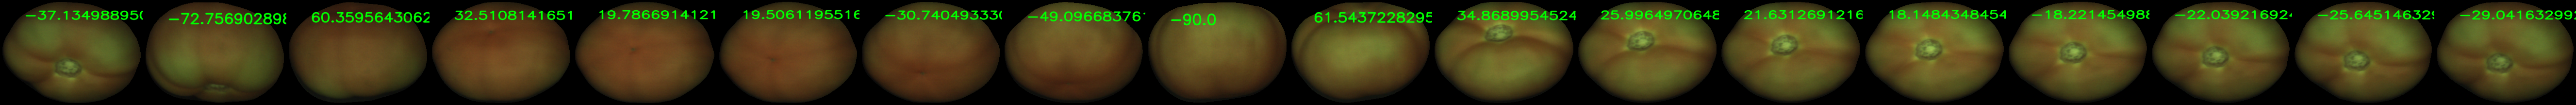

In [18]:
large_image_path = 'oblate_angles.png'
Image(filename=large_image_path, width=2000)

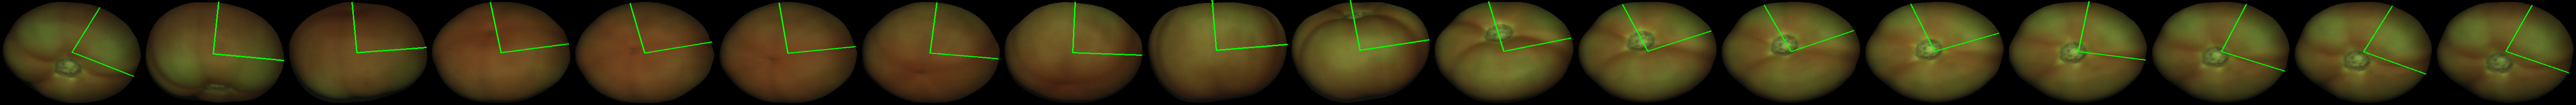

In [19]:
large_image_path = 'oblate_axes.png'
Image(filename=large_image_path, width=2000)

In [20]:
for index, image_name in enumerate(image_files):
    # Read current image
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)

    # OBLATE